
# 1d analytical case for comparing the transform and mask method


In [ ]:
import xarray as xr
import xgcm
import numpy as np
import matplotlib.pyplot as plt

dt = 0.01
dx = 0.02
t = np.arange(1,41.,dt)
x = np.arange(0,3.02,dx)
x2, t2 = np.meshgrid(x, t)

T = 15/np.pi * np.cos(np.pi*t2) + 3/np.pi * np.cos(np.pi/3*t2) + 2*np.sin(0.3*np.pi*(x2-t2)) + 4*np.sin(0.7*np.pi*(x2-t2)) + 10.
Tdot = -15. * np.sin(np.pi*t2) - 1. * np.sin(np.pi/3*t2)
Tx = 2*0.3*np.pi*np.cos(0.3*np.pi*(x2-t2)) + 4*0.7*np.pi*np.cos(0.7*np.pi*(x2-t2))

yearlyNt = int(2*np.pi/np.pi/dt )
nyear = int( len(t)/yearlyNt )

In [226]:
print(T.max(),T.min())

21.729577951308233 -1.729577951308233


In [227]:
dtcenters = 0.01
tcenters = np.arange(-2,22,dtcenters)

# method mask

In [241]:
dmdt_method1 = np.zeros([len(tcenters),len(t)])
M_method1    = np.zeros([len(tcenters),len(t)])
gmat_method1 = np.zeros([len(tcenters),len(t)])
gadv_method1 = np.zeros([len(tcenters),len(t)])
gadv_left = np.zeros([len(tcenters),len(t)])
gadv_right = np.zeros([len(tcenters),len(t)])

for i in range( len(tcenters) ):
    
    M_method1[i,:] = (T >= tcenters[i]).sum(axis=1)*dx   #Tprime shape (ntime,nx)
    
    # transformation
    mask2 = (T >= tcenters[i]+dtcenters) & (x2 <= 3.0)      # shape (ntime, nx), 
    Tdotmasked = np.where(mask2, Tdot, 0.0)
    mat2 = (Tdotmasked*dx).sum(axis=1)   # shape (ntime,)    

    mask1 = (T >= tcenters[i]-dtcenters) & (x2 <= 3.0)       # shape (ntime, nx), 
    Tdotmasked = np.where(mask1, Tdot, 0.0)
    mat1 = (Tdotmasked*dx).sum(axis=1)   # shape (ntime,)   

    gmat_method1[i,:] = -(mat2-mat1)/(2*dtcenters)

    # adv
    leftmask = (T >= tcenters[i]) & (x2 == 0) 
    uu = np.ones(T.shape)
    gadv_left = (-uu*leftmask*1.).sum(axis=1)
    
    rightmask = (T >= tcenters[i]) & (x2 == 3) 
    gadv_right = (-uu*rightmask*1.).sum(axis=1)
    
    gadv_method1[i,:] = gadv_right - gadv_left
    
dmdt_method1 = (M_method1[:,2:]-M_method1[:,0:-2])/dt/2.

M_method1 = xr.DataArray(M_method1, dims=['tcenters','t'], coords={'tcenters':tcenters, 't':t })


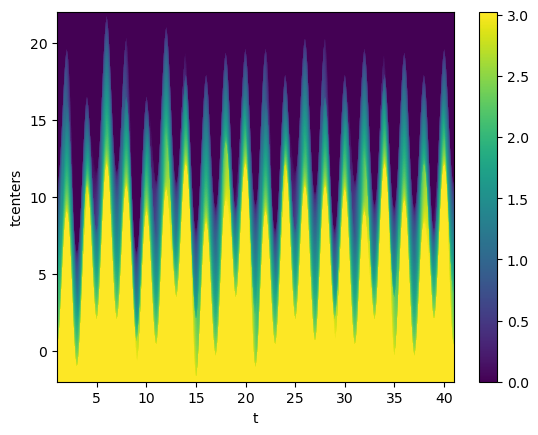

In [243]:
M_method1.plot()

# method transform

In [229]:
import numpy as np
import xarray as xr
import xgcm

# -----------------------------
# 原始网格和数据
# -----------------------------

T_da = xr.DataArray(T, dims=['t','x'], coords={'t': t, 'x': x})
Tdot_da =  xr.DataArray(Tdot,dims=['t','x'], coords={'t': t, 'x': x})
uuleft = np.zeros(T.shape)
uuleft[x2==0] = 1.
uuright = np.zeros(T.shape)
uuright[x2==3] = 1.
adv_lda =  xr.DataArray(uuleft,dims=['t','x'], coords={'t': t, 'x': x})
adv_rda =  xr.DataArray(uuright,dims=['t','x'], coords={'t': t, 'x': x})

# -----------------------------
# 构建 outer 坐标和 dx_array
# -----------------------------
x_outer = np.empty(len(x)+1)
x_outer[1:-1] = 0.5 * (x[:-1] + x[1:])
x_outer[0] = x[0] - 0.5*dx
x_outer[-1] = x[-1] + 0.5*dx
x_outer_da = xr.DataArray(x_outer, dims=['x_outer'])

dx_array = np.diff(x_outer)
dx_da = xr.DataArray(dx_array, dims=['x'], coords={'x': x})
dx_da = dx_da.expand_dims({'t': t}).transpose('t','x')

# -----------------------------
# 定义目标温度 bin
# -----------------------------
dtcenters = 0.01
tcenters = np.arange(-2,22,dtcenters)

tcen_outer = np.empty(len(tcenters)+1)
tcen_outer[1:-1] = 0.5 * (tcenters[:-1] + tcenters[1:])
tcen_outer[0] = tcenters[0] - 0.5*dtcenters
tcen_outer[-1] = tcenters[-1] + 0.5*dtcenters
tcen_outer = xr.DataArray(tcen_outer, dims=['tcenter'])

# -----------------------------
# 构建 Dataset 和 xgcm Grid
# -----------------------------

ds = xr.Dataset({
    'dx': dx_da,
    'T' : T_da,
    'Tdot':Tdot_da*dx,
    'adv_left':adv_lda,
    'adv_right':adv_rda})
ds = ds.assign_coords({'x_outer': x_outer})
grid = xgcm.Grid(ds, coords={'X':{'center':'x', 'outer':'x_outer'}}, periodic=False, autoparse_metadata=False)
#grid = xgcm.Grid(ds, coords={'X':{'center':'x'}}, periodic=False, autoparse_metadata=False)


ds['T_outer'] = grid.interp(ds.T, 'X', boundary='extend')
ds['T_outer']
# -----------------------------
# 5️conservative transform
# -----------------------------
thickness = grid.transform(ds['dx'], 'X', 
    target=tcen_outer,
    method='conservative',
    target_data=ds.T_outer)

Tdot_theta = grid.transform(ds['Tdot'], 'X', 
    target=tcen_outer, 
    method='conservative',
    target_data=ds.T_outer)

ladv_theta = grid.transform(ds['adv_left'], 'X', 
    target=tcen_outer, 
    method='conservative',
    target_data=ds.T_outer)

radv_theta = grid.transform(ds['adv_right'], 'X', 
    target=tcen_outer, 
    method='conservative',
    target_data=ds.T_outer)

thickness = thickness.fillna(0)
Tdot_theta = Tdot_theta.fillna(0)
ladv_theta = ladv_theta.fillna(0)
radv_theta = radv_theta.fillna(0)


# -----------------------------
# 6️累积 > tcenter
# -----------------------------
thickness_cum = thickness.isel(tcenter=slice(None, None, -1)).cumsum(dim='tcenter').isel(tcenter=slice(None, None, -1))
thickness_trend = thickness_cum.diff('t') / dt 
thickness_trend = thickness_trend.assign_coords({'t': t[0:-1]})

# budgets
gmat = np.zeros([len(t),len(tcenters)])
for i in range(0,len(tcenters)-1):
    gmat[:,i] = ((Tdot_theta[:,i]+Tdot_theta[:,i-1])/2)/dtcenters
    #gmat[:,i] = Tdot_theta[:,i]/dtcenters

gmat = xr.DataArray(gmat[0:-1,:],
    dims=['t', 'tcenter'],
    coords={'t': t[0:-1], 'tcenter': tcenters})

#
#gadv = ladv_theta[0:-1,:]  - radv_theta[0:-1,:]
#gadv_cum = gadv.isel(tcenter=slice(None, None, -1)).cumsum(dim='tcenter').isel(tcenter=slice(None, None, -1))


ladv_theta_cum = ladv_theta.isel(tcenter=slice(None, None, -1)).cumsum(dim='tcenter').isel(tcenter=slice(None, None, -1))
radv_theta_cum = radv_theta.isel(tcenter=slice(None, None, -1)).cumsum(dim='tcenter').isel(tcenter=slice(None, None, -1))
gadv_cum       = ladv_theta_cum[0:-1,:] - radv_theta_cum[0:-1,:]



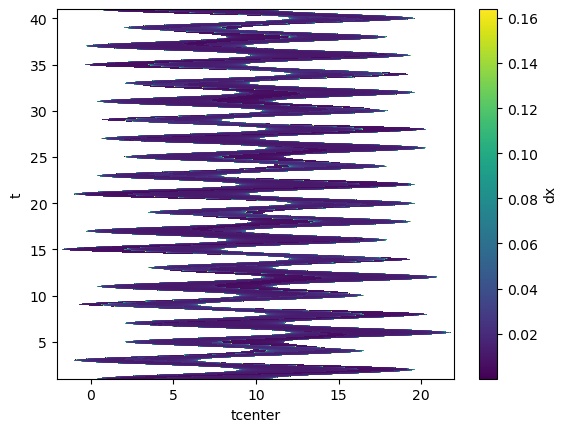

In [103]:
thickness.where(thickness!=0).plot()

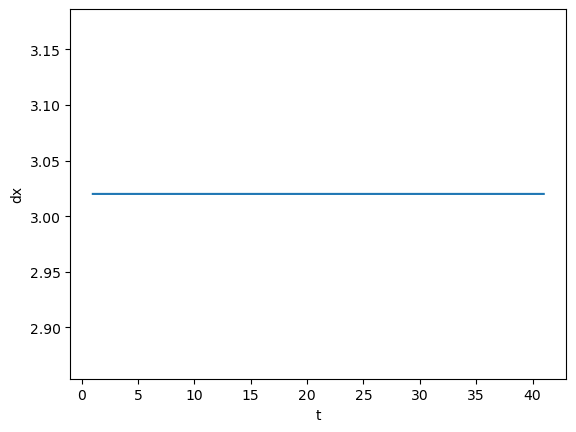

In [104]:
thickness.sum("tcenter").plot()

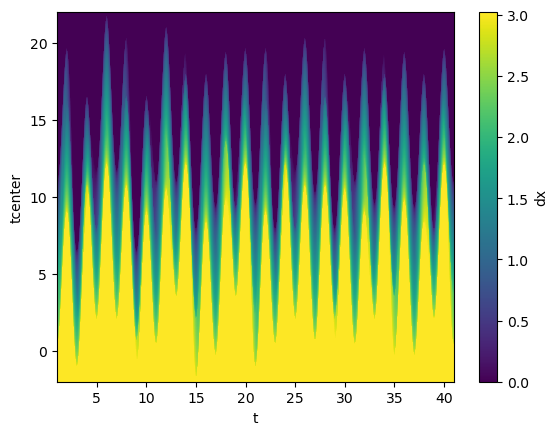

In [105]:
thickness_cum.plot(x="t")

# the difference of Mass between the transform and mask method!

(4.5, 5.5)

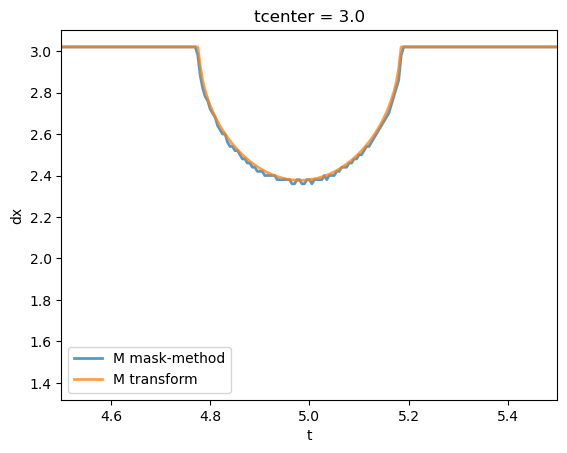

In [113]:
M_method1.isel(tcenters=100).plot(label='M mask-method',linewidth=2,alpha=0.75)
thickness_cum.isel(tcenter=100).plot(label='M transform',linewidth=2,alpha=0.75,linestyle='-')
plt.legend()
plt.xlim(4.5,5.5)

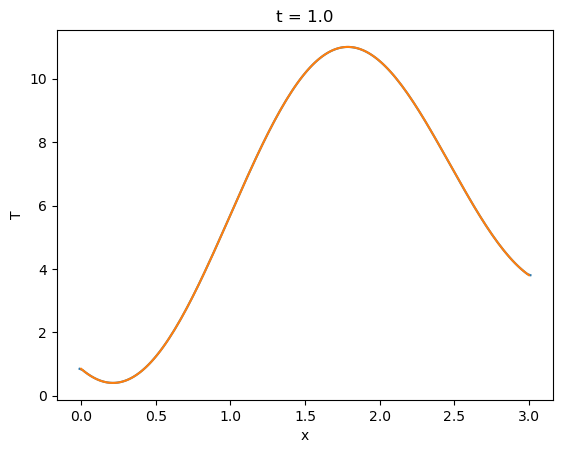

In [115]:
ds['T_outer'][0].plot()
ds['T'][0].plot()

In [ ]:
(thickness_trend - gadv_cum).cumsum("tcenter").plot(x="t", vmin=-3, vmax=3, cmap="RdBu_r")

In [139]:
gadv

<xarray.DataArray (t: 7999, tcenter: 610)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * t        (t) float64 1.0 1.005 1.01 1.015 1.02 ... 40.97 40.98 40.98 40.99
  * tcenter  (tcenter) float64 -2.0 -1.99 -1.98 -1.97 ... 4.06 4.07 4.08 4.09

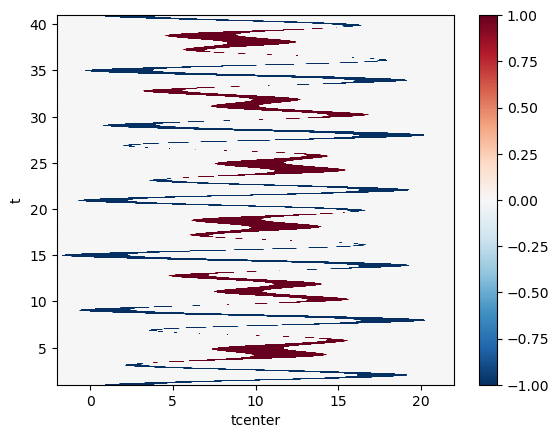

In [286]:
gadv_cum.plot()

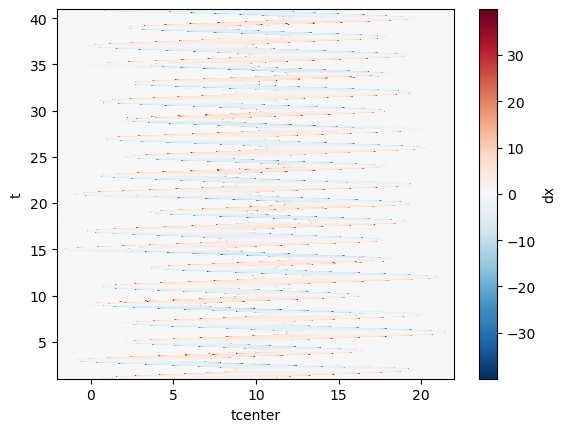

In [120]:
thickness_trend.plot()

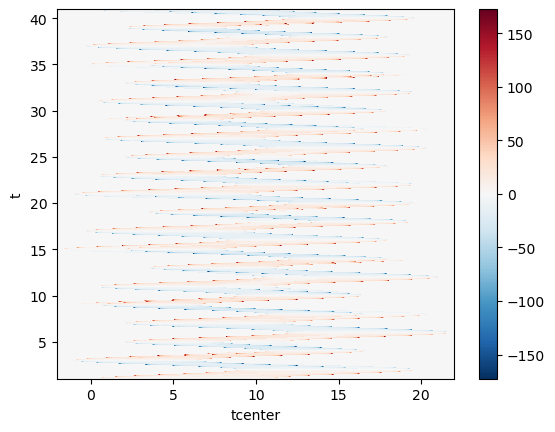

In [136]:
gmat.plot()

# the difference of watermass budget between the transform and mask method

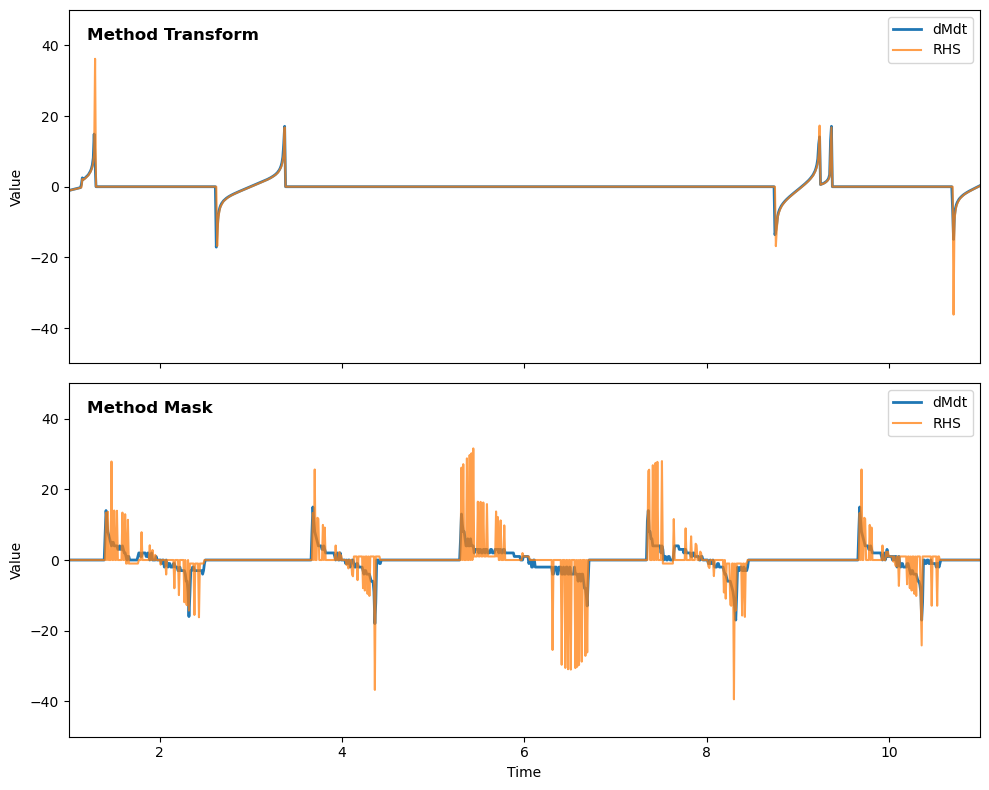

In [285]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True,sharey=True)

# 上行：方法0
axs[0].plot(thickness_trend.t, thickness_trend.isel(tcenter=400), label='dMdt', linewidth=2)
axs[0].plot(gadv_cum.t, gadv_cum.isel(tcenter=400).values + gmat.isel(tcenter=400).values, 
            label='RHS', alpha=0.75)
axs[0].legend(loc='upper right')  # 图例放右上角，避免覆盖文字
axs[0].text(0.02, 0.95, 'Method Transform', transform=axs[0].transAxes,
            fontsize=12, fontweight='bold', va='top', ha='left')
axs[0].set_xlim(1, 11)
axs[0].set_ylim(-50,50)

axs[0].set_ylabel('Value')

# 下行：方法1
axs[1].plot(t[1:-1], dmdt_method1[1600,:], label='dMdt', linewidth=2)
axs[1].plot(t[1:-1], gadv_method1[1600,1:-1] + gmat_method1[1600,1:-1], 
            label='RHS', alpha=0.75)
axs[1].legend(loc='upper right')
axs[1].text(0.02, 0.95, 'Method Mask', transform=axs[1].transAxes,
            fontsize=12, fontweight='bold', va='top', ha='left')
axs[1].set_xlim(1, 11)
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Value')
axs[1].set_ylim(-50,50)

plt.tight_layout()
plt.show()



(1.0, 11.0)

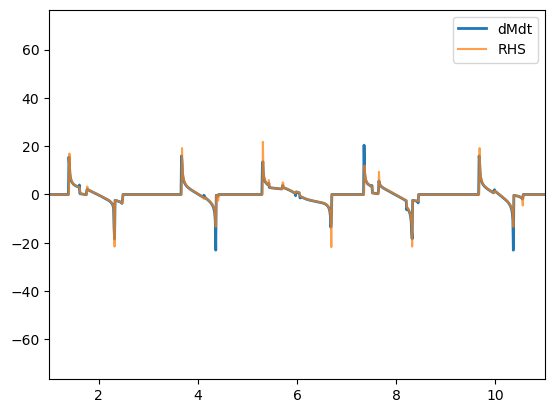

In [274]:
import matplotlib.pyplot as plt

plt.plot(thickness_trend.t, thickness_trend.isel(tcenter=1600),label='dMdt',linewidth=2)
#plt.plot(gadv_cum.t, ( gadv_cum.isel(tcenter=1600).values + gmat.isel(tcenter=1600).values), label='RHS',alpha=0.75)
plt.plot(gadv_cum.t, ( gadv_cum.isel(tcenter=1600).values + gmat.isel(tcenter=1600).values), label='RHS',alpha=0.75)

plt.legend()
plt.xlim(1,11)

(420.0, 520.0)

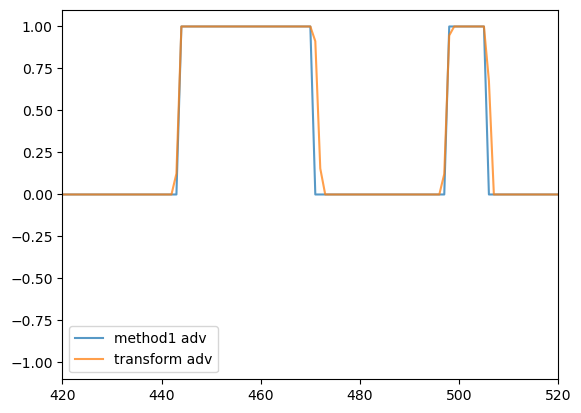

In [268]:
plt.plot( gadv_method1[1600,0:], label='method1 adv',alpha=0.75)
plt.plot( gadv_cum.isel(tcenter=1600).values, label='transform adv',alpha=0.75)

plt.legend()
plt.xlim(420,520)

(5.0, 6.25)

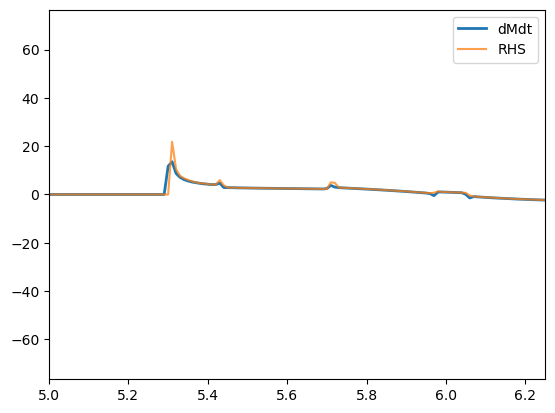

In [259]:
import matplotlib.pyplot as plt

plt.plot(thickness_trend.t, thickness_trend.isel(tcenter=1600),label='dMdt',linewidth=2)
#plt.plot(gadv.t, (gmat+gadv_cum).isel(tcenter=1600),label='RHS',alpha=0.75)
plt.plot(gadv_cum.t, ( gadv_cum.isel(tcenter=1600).values + gmat.isel(tcenter=1600).values), label='RHS',alpha=0.75)

plt.legend()
plt.xlim(5,6.25)

(1.0, 5.0)

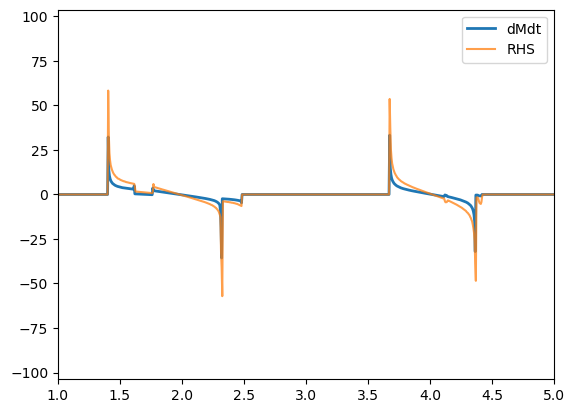

In [210]:
import matplotlib.pyplot as plt

plt.plot(thickness_trend.t, thickness_trend.isel(tcenter=800),label='dMdt',linewidth=2)
plt.plot(gadv.t, (gmat+gadv_cum).isel(tcenter=800),label='RHS',alpha=0.75)
plt.legend()
plt.xlim(1,5)

(1.0, 5.0)

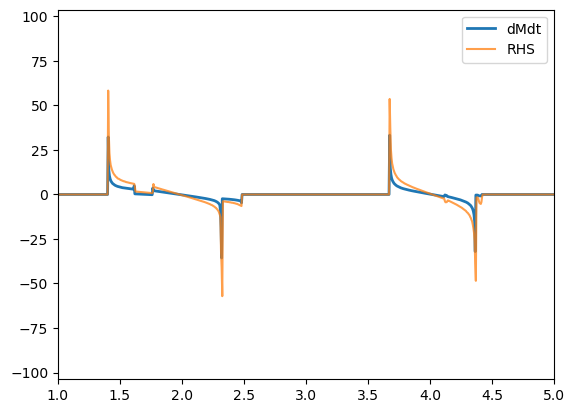

In [209]:
import matplotlib.pyplot as plt

plt.plot(thickness_trend.t, thickness_trend.isel(tcenter=800),label='dMdt',linewidth=2)
plt.plot(gadv.t, (gadv_cum.isel(tcenter=800).values + gmat.isel(tcenter=800).values), label='RHS',alpha=0.75)
plt.legend()
plt.xlim(1,5)

In [208]:
thickness_trend.tcenter[800]

<xarray.DataArray 'tcenter' ()>
array(14.)
Coordinates:
    tcenter  float64 14.0

In [161]:
thickness_trend.tcenter[320]

<xarray.DataArray 'tcenter' ()>
array(14.)
Coordinates:
    tcenter  float64 14.0

(1.0, 5.0)

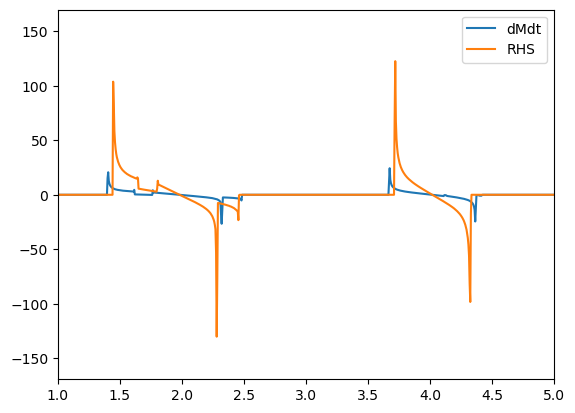

In [205]:
import matplotlib.pyplot as plt

plt.plot(gadv.t, thickness_trend.isel(tcenter=320),label='dMdt')
plt.plot(gadv.t, (gmat+gadv_cum).isel(tcenter=320),label='RHS')
plt.legend()
plt.xlim(1,5)

(1.0, 5.0)

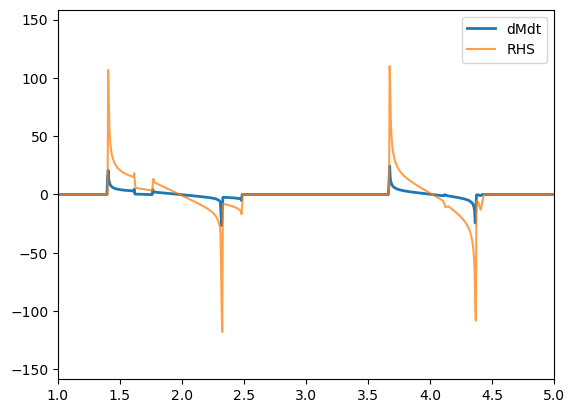

In [206]:
import matplotlib.pyplot as plt

plt.plot(thickness_trend.t, thickness_trend.isel(tcenter=320),label='dMdt',linewidth=2)
#plt.plot(gadv.t, (gmat-gadv_cum).isel(tcenter=320),label='RHS',alpha=0.75)

plt.plot(gadv.t, (gadv_cum.isel(tcenter=320).values + gmat.isel(tcenter=320).values), label='RHS',alpha=0.75)
plt.legend()
plt.xlim(1,5)

In [186]:
gadv_cum

<xarray.DataArray (t: 7999, tcenter: 480)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * t        (t) float64 1.0 1.005 1.01 1.015 1.02 ... 40.97 40.98 40.98 40.99
  * tcenter  (tcenter) float64 -2.0 -1.95 -1.9 -1.85 ... 21.8 21.85 21.9 21.95

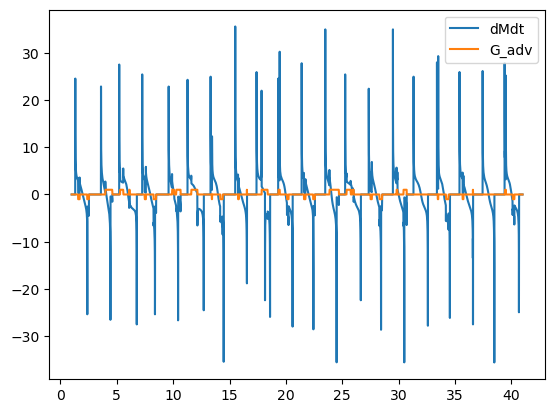

In [182]:
plt.plot(thickness_trend.t, thickness_trend.isel(tcenter=300),label='dMdt')
#plt.plot(gadv.t, (gmat).isel(tcenter=300),label='G_amt')
plt.plot(gadv.t, (gadv_cum).isel(tcenter=300),label='G_adv')
plt.legend()

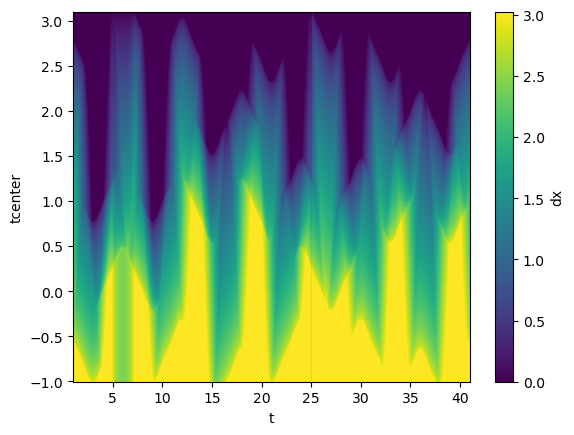

In [25]:
(thickness_cum.T).plot()

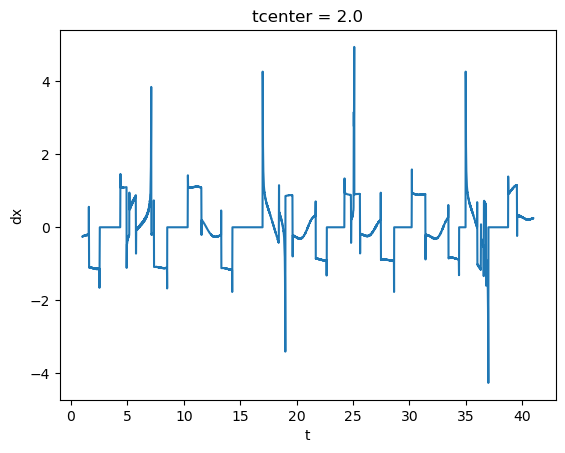

In [26]:
thickness_trend[:,300].plot()

In [ ]:
dmdt = np.zeros([len(tcenters),len(t)])
M    = np.zeros([len(tcenters),len(t)])
gmat = np.zeros([len(tcenters),len(t)])
gadv = np.zeros([len(tcenters),len(t)])
gadv_left = np.zeros([len(tcenters),len(t)])
gadv_right = np.zeros([len(tcenters),len(t)])

for i in range( len(tcenters) ):
    
    M[i,:] = (T >= tcenters[i]).sum(axis=1)*dx   #Tprime shape (ntime,nx)
    
    # transformation
    mask2 = (T >= tcenters[i]+dtcenters) & (x2 <= 3)      # shape (ntime, nx), 
    Tdotmasked = np.where(mask2, Tdot, 0.0)
    mat2 = (Tdotmasked*dx).sum(axis=1)   # shape (ntime,)    

    mask1 = (T >= tcenters[i]-dtcenters) & (x2 <= 3)       # shape (ntime, nx), 
    Tdotmasked = np.where(mask1, Tdot, 0.0)
    mat1 = (Tdotmasked*dx).sum(axis=1)   # shape (ntime,)   

    gmat[i,:] = -(mat2-mat1)/(2*dtcenters)

    # adv
    leftmask = (T >= tcenters[i]) & (x2 == 0) 
    uu = np.ones(T.shape)
    gadv_left = (-uu*leftmask*1.).sum(axis=1)
    
    rightmask = (T >= tcenters[i]) & (x2 == 3) 
    gadv_right = (-uu*rightmask*1.).sum(axis=1)
    
    gadv[i,:] = gadv_right - gadv_left
    
dmdt = (M[:,2:]-M[:,0:-2])/dt/2.


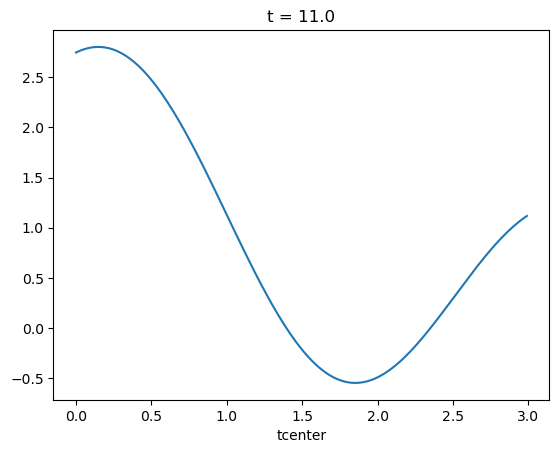

In [12]:
T_theta[1000,:].plot()

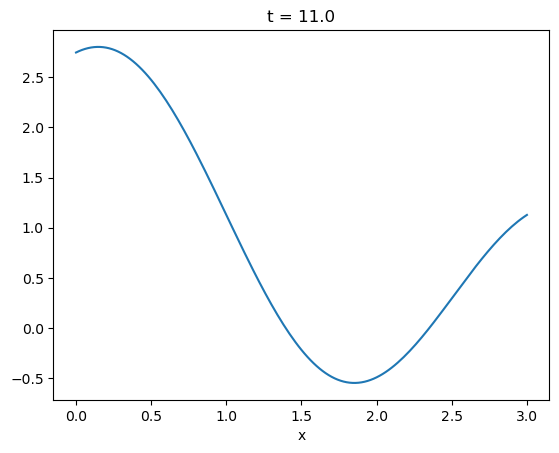

In [11]:
da[1000,:].plot()